In [2]:
import pandas as pd
import os
import random
import gensim.models.doc2vec
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
from gensim.models.doc2vec import Doc2Vec
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import networkx as nx
from random import randint 
from itertools import count
import networkx as nx


def tokenize(text, stopwords, max_len = 20):
    return [token for token in gensim.utils.simple_preprocess(text, max_len=max_len) if token not in stopwords]

def target_doc (df):
    articles = df.values.tolist()
    articles_flat = [item for sublist in articles for item in sublist]
    tagged_docs = [gensim.models.doc2vec.TaggedDocument(tokenize(text, [], max_len=200), [i]) for i, text in enumerate(articles_flat)]
    return tagged_docs

def pick_random_word(model, threshold=10):
    # pick a random word with a suitable number of occurences
    while True:
        word = random.choice(model.wv.index_to_key)
        if model.wv.get_vecattr(word, "count") > threshold:
            return word
spec_chars = ["!",'"',"#","%","&","'","(",")",
            "*","+",",","-",".","/",":",";","<",
            "=",">","?","@","[","\\","]","^","_",
            "`","{","|","}","~","–", "\xc2", "\xa0",
            "\x80", "\x9c", "\x99", "\x94", "\xad", "\xe2", "\x9d"]

In [3]:
keywords = ['black', 'haitian', 'jamaican', 'dominican', 'women', 'chinese']
Black_keywords = ['man', 'woman', 'men', 'women', 'male', 'female', 'person', 'people', 'community', 'neighborhood', 'child', 'cildren', 'kid', 'youth', 'business', 'company']
Black_ethnicities = ['black', 'cape verdean', 'afro latino', 'afro latina', 'haitian', 'african american', 'african-american', 'caribbean', 'jamaican', 'dominican', 'west indian']

In [4]:
#bostonglobe2014-----------------------
df_14 = pd.read_csv('./data-source/bostonglobe2014.csv')
for char in spec_chars:
    df_14['text'] = df_14['text'].str.replace(char, ' ')
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, epochs=40, window=2, dm=1)
model.build_vocab(target_doc (df_14))
model.train(target_doc (df_14), total_examples=model.corpus_count, epochs=model.epochs)
vector = model.infer_vector(Black_ethnicities)


<ipython-input-4-88f6475f48e1>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_14['text'] = df_14['text'].str.replace(char, ' ')


In [23]:
def compute_similar_words(model,source_word, topn=5):
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words    

def compute_similar_words_for_all_tasks(model,topn=5):
    columns = ['word'+str(i-1) for i in range(1,topn+2)]
    df = pd.DataFrame(data=None,columns=columns)
    for source_word in keywords:
        similar_words = compute_similar_words(model,source_word,topn)
        df.loc[len(df)] = similar_words
    for i in range(1,len(similar_words)):
        sec_similar_words = compute_similar_words(model,similar_words[i],topn)
        df.loc[len(df)] = sec_similar_words
    # df.to_csv('./similar_words_task/similar_words_task_2014.csv')
    # df.to_csv('./similar_words_task/similar_words_task_2015.csv')
    # df.to_csv('./similar_words_task/similar_words_task_2016.csv')
    # df.to_csv('./similar_words_task/similar_words_task_2017.csv')
    df.to_csv('./similar_words_task/similar_words_task_2018.csv')

words = compute_similar_words_for_all_tasks(model)

In [24]:
words = pd.read_csv('./similar_words_task/similar_words_task_2014.csv')
# words = pd.read_csv('./similar_words_task/similar_words_task_2015.csv')
# words = pd.read_csv('./similar_words_task/similar_words_task_2016.csv')
# words = pd.read_csv('./similar_words_task/similar_words_task_2017.csv')
# words = pd.read_csv('./similar_words_task/similar_words_task_2018.csv')

G = nx.Graph()
j = 1
for i, row in words.iterrows():
    for j in range(1,len(row)):
        G.add_node(i,label=row[j])
    for j in range(1,len(row)):
        G.add_edge(row[1], row[j])

In [25]:
remove = [node for node,degree in dict(G.degree()).items() if degree > 2]
print(remove)

['black', 'haitian', 'dominican', 'verdean', 'jamaican', 'women', 'chinese', 'peruvian', 'émigré', 'baked', 'fluent']


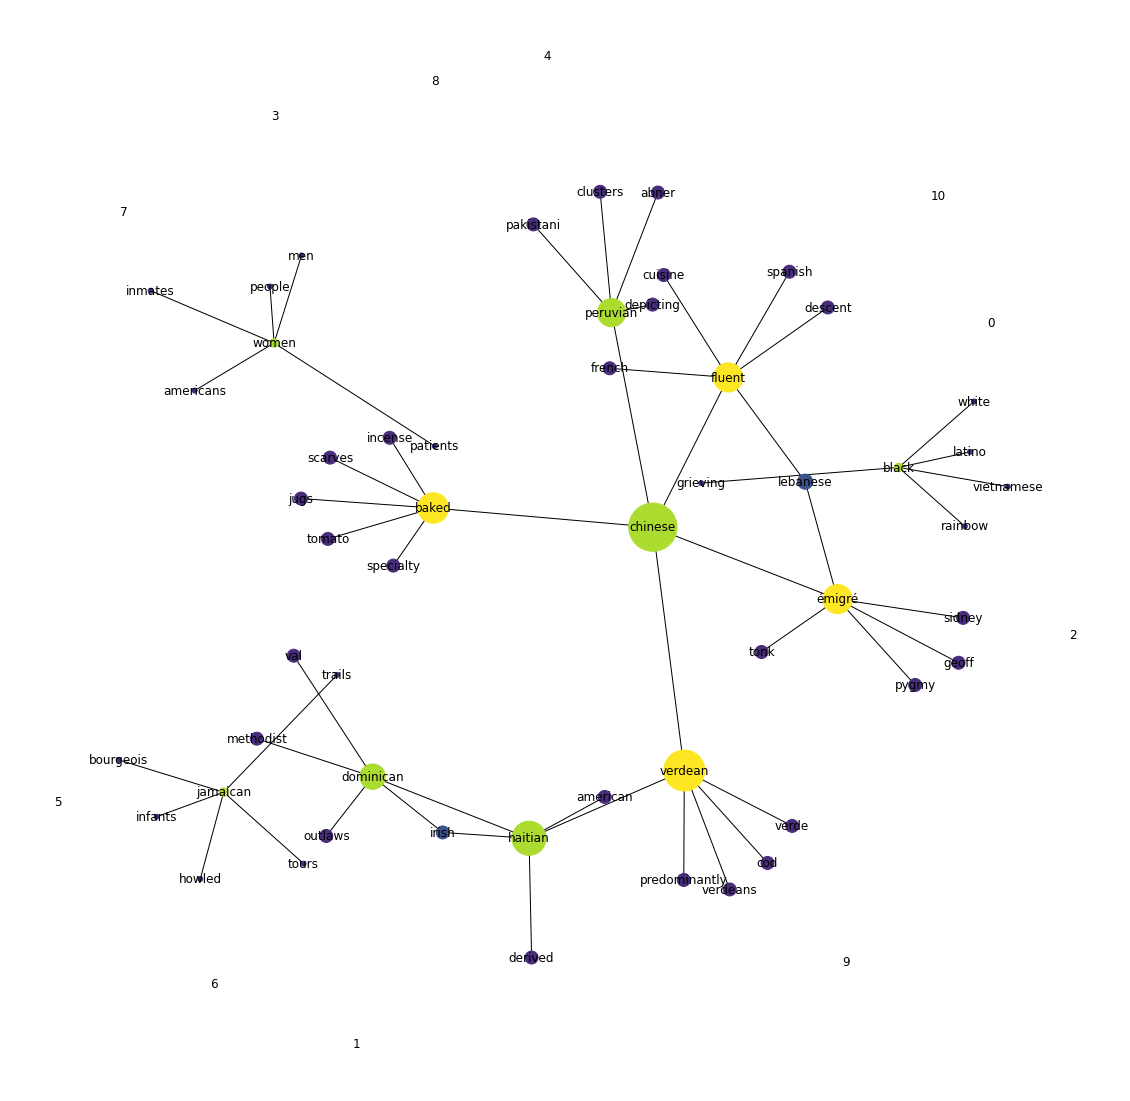

In [26]:
pos = nx.spring_layout(G,k=0.3)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')
plt.savefig("../img/network-graph.png")
plt.show()
